# Defining torch datasets

In [1]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
assert os.path.isdir('data')
current_file_path = os.path.abspath('')
print(current_file_path)

/data/l989o/deployed/a
/data/l989o/deployed/a


In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
import skimage
import skimage.io
import torch
import math
import cv2
import vigra
import pandas as pd
from data import file_path
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
import splits

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [3]:
def file_path_old_data(f):
    return os.path.join(current_file_path, 'data/spatial_uzh_processed', f)


def file_path(f):
    return os.path.join(current_file_path, 'data/spatial_uzh_processed/a', f)

In [4]:
CHANNEL_NAMES = ['H3tot', 'H3met', 'CK5', 'Fibronectin', 'CK19', 'CK8/18', 'TWIST1', 'CD68', 'CK14', 'SMA',
                 'Vimentin', 'Myc', 'HER2', 'CD3', 'H3phospho', 'ERK1/2', 'SLUG', 'ER', 'PR', 'p53', 'CD44',
                 'EpCAM', 'CD45', 'GATA3', 'CD20', 'betaCatenin', 'CAIX', 'Ecadherin', 'Ki67', 'EGFR', 'S6',
                 'Sox9', 'vWf_CD31', 'mTOR', 'CK7', 'panCK', 'cPARP_cCasp3', 'DNA1', 'DNA2']
                 
CHANNELS_TO_KEEP = [8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                    23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                    36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]

assert len(CHANNEL_NAMES) == len(CHANNELS_TO_KEEP)

In [5]:
def get_split(split):
    assert split in ['train', 'validation', 'test']
    if split == 'train':
        return splits.train
    elif split == 'validation':
        return splits.validation
    else:
        return splits.test

## Ome and masks datasets

In [6]:
class OmeDataset(Dataset):
    def __init__(self, split):
        super().__init__()
        self.split = split
        self.filenames = get_split(self.split)
        self.channels_count = len(CHANNELS_TO_KEEP)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        f = os.path.join('data/OMEandSingleCellMasks/ome/', filename)
        ome = skimage.io.imread(f)
        ome = np.moveaxis(ome, 0, 2)
        ome = torch.from_numpy(ome).float()
        ome = ome[:, :, CHANNELS_TO_KEEP]
        ome = ome.float()
        return ome

In [7]:
class MasksDataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.split = split
        self.filenames = get_split(self.split)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        ome_filename = self.filenames[i]
        masks_file = file_path_old_data('relabelled_masks.hdf5')
        with h5py.File(masks_file, 'r') as f5:
            masks = f5[ome_filename + '/masks'][...]
        return masks

In [8]:
ds0 = OmeDataset('train')
print(ds0[0].shape)

ds1 = MasksDataset('train')
print(ds1[0].shape)

torch.Size([421, 833, 39])
(421, 833)


## Hot pixel removalclass OmeDataset(Dataset):

In [9]:
class OmeDataset(Dataset):
    def __init__(self, split, hot_pixel_filtering=True):
        super().__init__()
        self.split = split
        self.filenames = get_split(self.split)
        self.channels_count = len(CHANNELS_TO_KEEP)
        self.hot_pixel_filtering = hot_pixel_filtering

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        filename = self.filenames[i]
        f = os.path.join('data/OMEandSingleCellMasks/ome/', filename)
        ome = skimage.io.imread(f)
        ome = np.moveaxis(ome, 0, 2)
        ome = ome[:, :, CHANNELS_TO_KEEP]
        
        if self.hot_pixel_filtering:
            kernel = np.ones((3, 3), dtype=np.uint8)
            kernel[1, 1] = 0
            maxs = cv2.dilate(ome, kernel, iterations=1, borderType=cv2.BORDER_REFLECT101)
            mask = ome - maxs >= 50
            c = ome[mask] - maxs[mask]
            a = np.sum(c)
            b = np.sum(ome)
            ome[mask] = maxs[mask]
            
        ome = torch.from_numpy(ome).float()
        return ome
    
ds0 = OmeDataset('train')
ds1 = OmeDataset('train', hot_pixel_filtering=False)

In [10]:
%%script false --no-raise-error

ome_index = 0
axes = plt.subplots(int(np.ceil(len(CHANNELS_TO_KEEP) / 6)), 6, figsize=(20, 20))[1].flatten()
for i in range(len(CHANNELS_TO_KEEP)):
    axes[i].imshow(ds0[ome_index][:, :, i] != ds1[ome_index][:, :, i], interpolation='nearest')
    axes[i].set_title(f'channel {i}')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(ds0[ome_index][:, :, 20] != ds1[ome_index][:, :, 20], interpolation='nearest')
plt.show()

## Accumulate features

In [11]:
p = file_path('accumulated_features')
os.makedirs(p, exist_ok=True)

In [12]:
def save_features(features, f5):
    f5['count'] = features['Count'][1:]
    f5['maximum'] = features['Maximum'][1:]
    f5['mean'] = features['Mean'][1:]
    f5['sum'] = features['Sum'][1:]
    f5['variance'] = features['Variance'][1:]
    f5['region_center'] = features['RegionCenter'][1:]
    if 'Median' in features:
        f5['median'] = features['Median'][1:]
    
def extract_features_for_ome(ome, masks, compute_median=False):
    ome = np.require(ome, requirements=['C'])
    vigra_ome = vigra.taggedView(ome, 'xyc')
    masks = masks.astype(np.uint32)
    features = ['Count', 'Maximum', 'Mean', 'Sum', 'Variance', 'RegionCenter']
    features = vigra.analysis.extractRegionFeatures(vigra_ome, labels=masks, ignoreLabel=0, features=features)
    features = {k: v for k, v in features.items()}
    if compute_median:
        labels = np.unique(masks)
        medians = []
        for label in tqdm(labels, desc='computing median', leave=False):
            medians_cell = []
            for i in range(ome.shape[2]):
                m = np.median(ome[:, :, i][masks == label])
                medians_cell.append(m)
            medians.append(medians_cell)
        features['Median'] = np.array(medians)
        assert features['Median'].shape == features['Mean'].shape
    return features

### Accumulate raw data

In [13]:
%%script false --no-raise-error

with h5py.File(file_path('accumulated_features/raw_accumulated.hdf5'), 'w') as f5:
    for split in tqdm(['train', 'validation', 'test'], desc='set split'):
        masks_ds = MasksDataset(split)
        ome_ds = OmeDataset(split)
        for i in tqdm(range(len(ome_ds)), desc='accumulating features', leave=False):
            ome = ome_ds[i].numpy()
            masks = masks_ds[i]
            features = extract_features_for_ome(ome, masks)
            group = '/' + ome_ds.filenames[i]
            if group not in f5:
                f5.create_group(group)
            save_features(features, f5[group])

### Accumulate transformed data

In [14]:
%%script false --no-raise-error

with h5py.File(file_path('accumulated_features/transformed_accumulated.hdf5'), 'w') as f5:
    for split in tqdm(['train', 'validation', 'test'], desc='set split'):
        masks_ds = MasksDataset(split)
        ome_ds = OmeDataset(split)
        for i in tqdm(range(len(ome_ds)), desc='accumulating features', leave=False):
            ome = ome_ds[i].numpy()
            ome = np.arcsinh(ome)
            masks = masks_ds[i]
            features = extract_features_for_ome(ome, masks)
            group = '/' + ome_ds.filenames[i]
            if group not in f5:
                f5.create_group(group)
            save_features(features, f5[group])

### Datasets accumulated features

In [15]:
class AccumulatedDataset(Dataset):
    def __init__(self, split, feature: str, from_raw: bool, transform: bool):
        self.split = split
        self.filenames = get_split(self.split)
        if from_raw:
            self.f = file_path('accumulated_features/raw_accumulated.hdf5')
        else:
            self.f = file_path('accumulated_features/transformed_accumulated.hdf5')
        self.feature = feature
        self.transform = transform
        assert not (not from_raw and transform)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, i):
        with h5py.File(self.f, 'r') as f5:
            x = f5[self.filenames[i] + f'/{self.feature}'][...]
            x = x.astype(np.float32)
            if self.transform:
                x = np.arcsinh(x)
            x = torch.from_numpy(x)
            return x

In [16]:
for feature in ['sum', 'maximum', 'mean', 'count']:
    for from_raw in [True, False]:
        for transform in [True, False]:
            if not from_raw and transform:
                continue
            ds = AccumulatedDataset('train', feature=feature, from_raw=from_raw, transform=transform)
            print(ds[0].shape)

torch.Size([2890, 39])
torch.Size([2890, 39])
torch.Size([2890, 39])
torch.Size([2890, 39])
torch.Size([2890, 39])
torch.Size([2890, 39])
torch.Size([2890, 39])
torch.Size([2890, 39])
torch.Size([2890, 39])
torch.Size([2890])
torch.Size([2890])
torch.Size([2890])


In [17]:
ds0 = AccumulatedDataset('train', feature='mean', from_raw=True, transform=False)
ds1 = AccumulatedDataset('train', feature='mean', from_raw=True, transform=True)
ds2 = AccumulatedDataset('train', feature='mean', from_raw=False, transform=False)

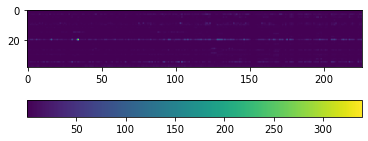

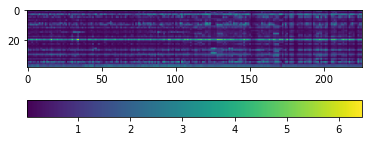

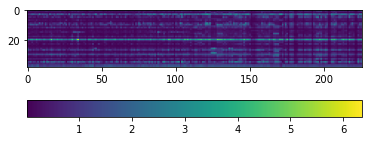

In [18]:
def get_z(ds):
    l = []
    for x in ds:
        l.append(np.mean(x.numpy(), axis=0, keepdims=True))
    z = np.concatenate(l, axis=0)
    return z

plt.figure()
plt.imshow(get_z(ds0).T)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(get_z(ds1).T)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(get_z(ds2).T)
plt.colorbar(orientation='horizontal')
plt.show()

In [61]:
class ScaledAccumulatedDataset(Dataset):
    def __init__(self, split, feature: str, from_raw: bool, transform: bool):
        self.accumulated_ds = AccumulatedDataset(split, feature, from_raw, transform)
        self.mu, self.std = self.get_mean_and_std(self.accumulated_ds)
        
    def __len__(self):
        return len(self.accumulated_ds)
    
    @staticmethod
    def get_mean_and_std(ds):
        l = []
        for x in ds:
            l.append(x.numpy())
        z = np.concatenate(l, axis=0)
        mu = np.mean(z, axis=0)
        std = np.std(z, axis=0)
        return mu, std
        
    def scale(self, x):
        return (x - self.mu) / self.std
    
    def scale_back(self, z):
        return self.mu + self.std * z
    
    def __getitem__(self, i):
        x = self.accumulated_ds[i]
        z = self.scale(x)
        return z
        
ds0 = ScaledAccumulatedDataset('train', feature='mean', from_raw=True, transform=False)
ds1 = ScaledAccumulatedDataset('train', feature='mean', from_raw=True, transform=True)
ds2 = ScaledAccumulatedDataset('train', feature='mean', from_raw=False, transform=False)

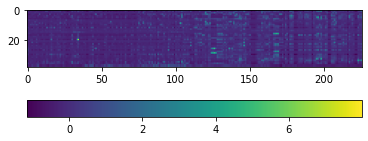

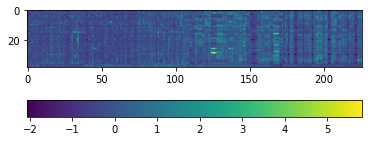

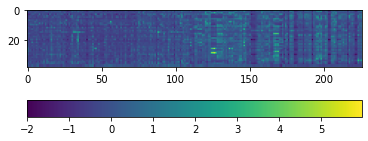

In [20]:
plt.figure()
plt.imshow(get_z(ds0).T)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(get_z(ds1).T)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(get_z(ds2).T)
plt.colorbar(orientation='horizontal')
plt.show()

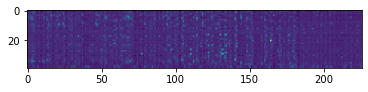

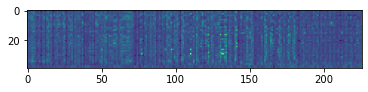

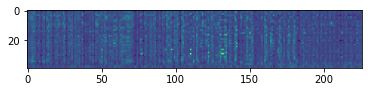

In [21]:
def sort_rows(m):
    l = []
    for x in ds:
        l.append(len(x))
    a = list(zip(*sorted(zip(l, list(range(len(l)))), key=lambda x: x[0])))[1]
    return m[a, :]
    
plt.figure()
plt.imshow(sort_rows(get_z(ds0)).T)
plt.show()

plt.figure()
plt.imshow(sort_rows(get_z(ds1)).T)
plt.show()

plt.figure()
plt.imshow(sort_rows(get_z(ds2)).T)
plt.show()

## Filtering cells by area

### Computing indices

In [22]:
%%script false --no-raise-error

for split in ['train', 'validation', 'test']:
    masks_ds = MasksDataset(split)
    all_areas = []
    all_ome_indices = []
    for masks in tqdm(masks_ds, desc=f'filtering cells by ares, {split} set'):
        m = masks.max()
        all_ome_indices.append(np.array([1] * m))
        for i in range(1, m + 1):
            mask = masks[masks == i]
            assert len(mask.shape) == 1
            all_areas.append(len(mask))

    areas = np.array(all_areas)
    ome_indices = np.concatenate(all_ome_indices)
    assert len(areas) == len(ome_indices)
    print(len(areas), 'cells in', split, 'set')

    min_area = 15
    max_area = 400
    plt.figure()
    plt.hist(areas, bins=100)
    plt.axvline(x=min_area, c='r')
    plt.axvline(x=max_area, c='r')
    plt.xlabel('cell area')
    plt.ylabel('count')
    plt.title(f'distribution of cell area, {split} set')
    plt.show()

    ok_size_cells = (areas >= min_area) & (areas <= max_area)
    pickle.dump(ok_size_cells, open(file_path(f'ok_size_cells_{split}.npy'), 'wb'))

In [23]:
class IndexInfo:
    def __init__(self, split):
        self.split = split
        self.filenames = get_split(self.split)
        
        self.unfiltered_begins = []
        self.unfiltered_ends = []
        self.filtered_begins = []
        self.filtered_ends = []
        ds = MasksDataset(self.split)
        self.ok_size_cells = pickle.load(open(file_path(f'ok_size_cells_{self.split}.npy'), 'rb'))
        i = 0
        j = 0
        for ome_index, masks in enumerate(ds):
            m = masks.max()
            begin = i
            end = begin + m
            i = end
            self.unfiltered_begins.append(begin)
            self.unfiltered_ends.append(end)
            
            ok = self.ok_size_cells[begin: end]
            begin = j
            end = begin + np.sum(ok)
            j = end
            self.filtered_begins.append(begin)
            self.filtered_ends.append(end)
            
{k: IndexInfo(k) for k in ['train', 'validation', 'test']}
print(list(zip(IndexInfo('train').unfiltered_begins, IndexInfo('train').unfiltered_ends)))

[(0, 2890), (2890, 6837), (6837, 10329), (10329, 13396), (13396, 16558), (16558, 19412), (19412, 23385), (23385, 26406), (26406, 28588), (28588, 31308), (31308, 33410), (33410, 36571), (36571, 40158), (40158, 42133), (42133, 45951), (45951, 47831), (47831, 50476), (50476, 54089), (54089, 56795), (56795, 58109), (58109, 59506), (59506, 63100), (63100, 65414), (65414, 68880), (68880, 72861), (72861, 74928), (74928, 77160), (77160, 80587), (80587, 83112), (83112, 86890), (86890, 89639), (89639, 92721), (92721, 96341), (96341, 100298), (100298, 103116), (103116, 105702), (105702, 109013), (109013, 111871), (111871, 114336), (114336, 116059), (116059, 118594), (118594, 122130), (122130, 125803), (125803, 127253), (127253, 130160), (130160, 132185), (132185, 134172), (134172, 137080), (137080, 141030), (141030, 143971), (143971, 145848), (145848, 148504), (148504, 149550), (149550, 152738), (152738, 156246), (156246, 157713), (157713, 161272), (161272, 163490), (163490, 166740), (166740, 170

### Filtering masks

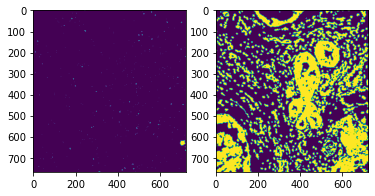

In [24]:
class FilteredMasksDataset(Dataset):
    def __init__(self, split):
        self.masks_ds = MasksDataset(split)
        self.index_info = IndexInfo(split)
        
    def __len__(self):
        return len(self.masks_ds)
    
    def __getitem__(self, i):
        masks = self.masks_ds[i]
        m = masks.max()
        v = np.arange(1, m + 1, dtype=np.int)
        begin = self.index_info.unfiltered_begins[i]
        end = self.index_info.unfiltered_ends[i]
        ok = self.index_info.ok_size_cells[begin: end]
        ok_labels = v[ok]
        not_ok = set(v.tolist()).difference(ok_labels.tolist())
        for label in not_ok:
            masks[masks == label] = 0
        return masks

ds0 = MasksDataset('train')    
m0 = ds0[5]
ds1 = FilteredMasksDataset('train')
m1 = ds1[5]

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(m0 != m1)
plt.subplot(1, 2, 2)
plt.imshow((m0 == m1) & (m0 != 0))
plt.show()

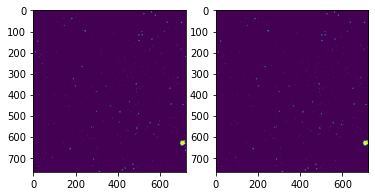

In [76]:
class FilteredMasksRelabeled(Dataset):
    def __init__(self, split):
        self.masks_ds = MasksDataset(split)
        self.index_info = IndexInfo(split)
        self.filtered_masks = FilteredMasksDataset(split)
        
    def __len__(self):
        return len(self.masks_ds)
    
    def get_indices_conversion_arrays(self, i):
        u = np.unique(self.filtered_masks[i])
        new_to_old = np.sort(u)
        m = np.max(new_to_old) # THE BUG IS HERE!!!!!!!!!!!
        old_to_new = np.zeros(m + 1, dtype=np.int)
        for uu in u:            
            i, = np.where(new_to_old == uu)
            old_to_new[uu] = i
        return new_to_old, old_to_new
    
    def __getitem__(self, i):
        new_to_old, old_to_new = self.get_indices_conversion_arrays(i)
        old = self.filtered_masks[i]
        new = old_to_new[old]
        return new
    
ds2 = FilteredMasksRelabeled('train')
m2 = ds2[5]
b0 = m0 != 0
b1 = m1 != 0
b2 = m2 != 0

assert np.all(b1 == b2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b0 != b1)
plt.subplot(1, 2, 2)
plt.imshow(b0 != b2)
plt.show()

### Relabelling expression

In [77]:
class ExpressionDataset(Dataset):
    def __init__(self, split):
        self.split = split
        self.ds = ScaledAccumulatedDataset(split, feature='mean', from_raw=True, transform=True)
        self.index_converter = FilteredMasksRelabeled(split).get_indices_conversion_arrays
        
    # the background is not an expression rows, so for instance there is no new row which corresponds to the background in the old cell labeling. The asserts will check that everything is ok
    def expression_old_to_new(self, old_e, i):
        new_to_old, old_to_new = self.index_converter(i)
        assert len(old_e) == len(old_to_new) + 1, (len(old_e), len(old_to_new) + 1, f'ome_index{i}')
        new = []
        for i, o in enumerate(old_to_new):
            if o == 0:
                continue
            new.append(old_e[(i, ), :])
        new_e = np.concatenate(new, axis=0)
        assert len(new_e) == np.max(old_to_new), (len(new_e), np.max(old_to_new))
        return new_e
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        e = self.ds[i]
        new_e = self.expression_old_to_new(e, i)
        return new_e

ds = ExpressionDataset('train')
for i in range(10):
    print(ds[i].shape)
    print(ds.ds[i].shape)

(2694, 39)
torch.Size([2890, 39])
(3535, 39)
torch.Size([3947, 39])


AssertionError: (3492, 3493, 'ome_index2')

In [81]:
for ome_index in range(5):
    f = file_path('accumulated_features/transformed_accumulated.hdf5')
    f5 = h5py.File(f, 'r')
    omes = OmeDataset('train').filenames
    e = f5[f'{omes[ome_index]}/mean'][...]
    print('e.shape =', e.shape)
    g = FilteredMasksRelabeled('train').get_indices_conversion_arrays
    new_to_old, old_to_new = g(ome_index)
    print(f'len(new_to_old) = {len(new_to_old)}, np.max(new_to_old) = {np.max(new_to_old)}, len(old_to_new) = {len(old_to_new)}, np.max(old_to_new) = {np.max(old_to_new)}')
    print()

e.shape = (2890, 39)
len(new_to_old) = 2695, np.max(new_to_old) = 2888, len(old_to_new) = 2889, np.max(old_to_new) = 2694

e.shape = (3947, 39)
len(new_to_old) = 3536, np.max(new_to_old) = 3945, len(old_to_new) = 3946, np.max(old_to_new) = 3535

e.shape = (3492, 39)
len(new_to_old) = 3054, np.max(new_to_old) = 3491, len(old_to_new) = 3492, np.max(old_to_new) = 3053

e.shape = (3067, 39)
len(new_to_old) = 2700, np.max(new_to_old) = 3065, len(old_to_new) = 3066, np.max(old_to_new) = 2699

e.shape = (3162, 39)
len(new_to_old) = 2693, np.max(new_to_old) = 3158, len(old_to_new) = 3159, np.max(old_to_new) = 2692



## Cell-level image features

In [ ]:
ds = OmeDataset('train')

# all the cells, not filtering
class Cell:
    def __init__(self, split, ome_index, cell_index):
        self.split = split
        self.ome_index = ome_index
        self.cell_index = cell_index
        self.ome_ds = OmeDataset(split)
        f = file_path('accumulated_features/raw_accumulated.hdf5')
        with h5py.File(f, 'r') as f5:
            o = self.ome_ds.filenames[self.ome_index]
            centers = f5[f'/{o}/region_center'][...]
        # because in the hdf5 file the background has been removed
        self.center = centers[cell_index - 1]
#         print(self.center)

In [63]:
ds = ExpressionDataset('train')
all_cells_train = []
for i, e in enumerate(tqdm(ds, desc='isolating all cells, train')):
    for j in range(len(e)):
        cell = Cell('train', i, j)
        all_cells_train.append(cell)
print(len(all_cells_train))

AssertionError: (3492, 3493)